In [14]:
# loading modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick

from stack_functions import getChoices, convert2USD

In [2]:
# setting up display
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']= 10, 10
plt.rcParams['font.size']=8

# __Load and quick exploration of the dataset__
___

In [3]:
# load data and data schema
df = pd.read_csv('../DataSets/StackOverflow/survey-results-public.csv')
df_sch = pd.read_csv('../DataSets/StackOverflow/survey-results-schema.csv')

In [4]:
df_sch.query('Column == "Professional"')

,Column,Question
1,Professional,Which of the following best describes you?


In [5]:
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## What kind of prodessional are represnted in this dataset?

In [6]:
f'There are "{df["Professional"].isna().sum()}" missing values in this category'

'There are "0" missing values in this category'

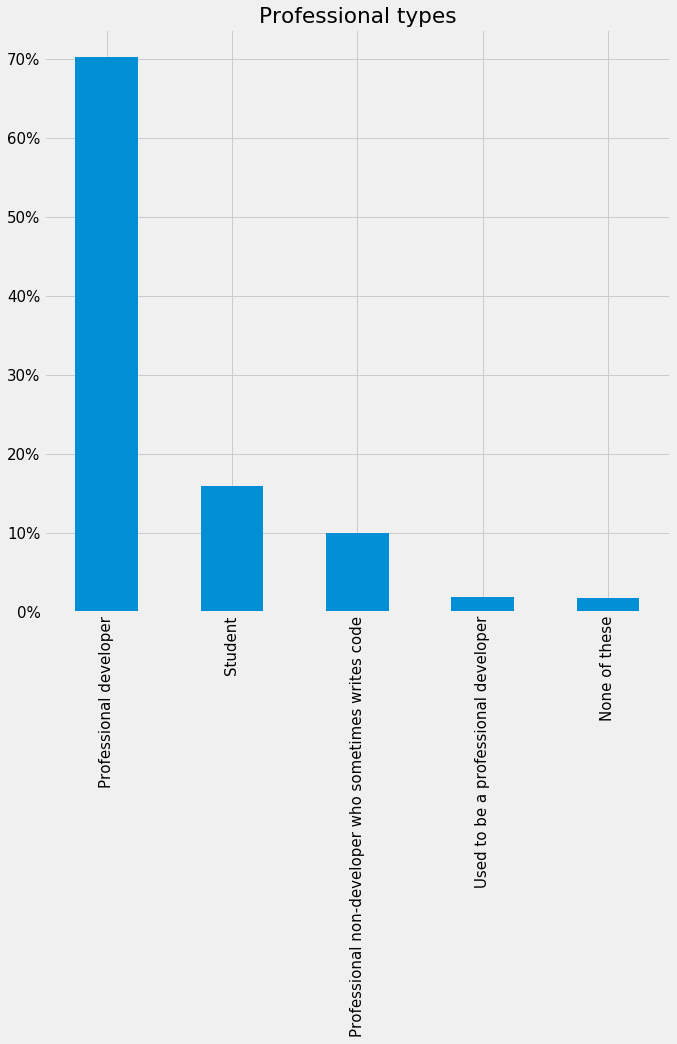

In [7]:
# shows count for each professional category
plt.rcParams['font.size']=15

perc_pro = df['Professional'].value_counts()/(df['Professional'].value_counts().sum())
ax = perc_pro.plot(kind='bar', title='Professional types')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

> __for the rest of this analysis we will focus on the "Profesional developer" only__

In [8]:
# We are keeping only "Professional developer"
df_pro = df.query('Professional == "Professional developer"')

# __Education Advices from "Professional"__
---

> We are using the ```getChoices()``` function to extract all unique possible choices in ```'CousinEducation'``` -> we will obtain all observations where each unique choices were found


In [9]:
dictEducAdv = getChoices(df_pro['CousinEducation'])
# count values for each category of 'CousinEducation' 
AdvCount = {k: len(v) for k, v in dictEducAdv.items()}
AdvCount

{'Get a job as a QA tester': 2690,
 'Conferences/meet-ups': 3986,
 'Take online courses': 10973,
 'Contribute to open source': 5398,
 'Buy books and work through the exercises': 8549,
 'Part-time/evening courses': 5464,
 'Participate in online coding competitions': 2392,
 'Other': 1772,
 'None of these': 385,
 'Bootcamp': 3875,
 "Master's degree": 1847,
 'Return to college': 3574,
 'Participate in hackathons': 1897}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

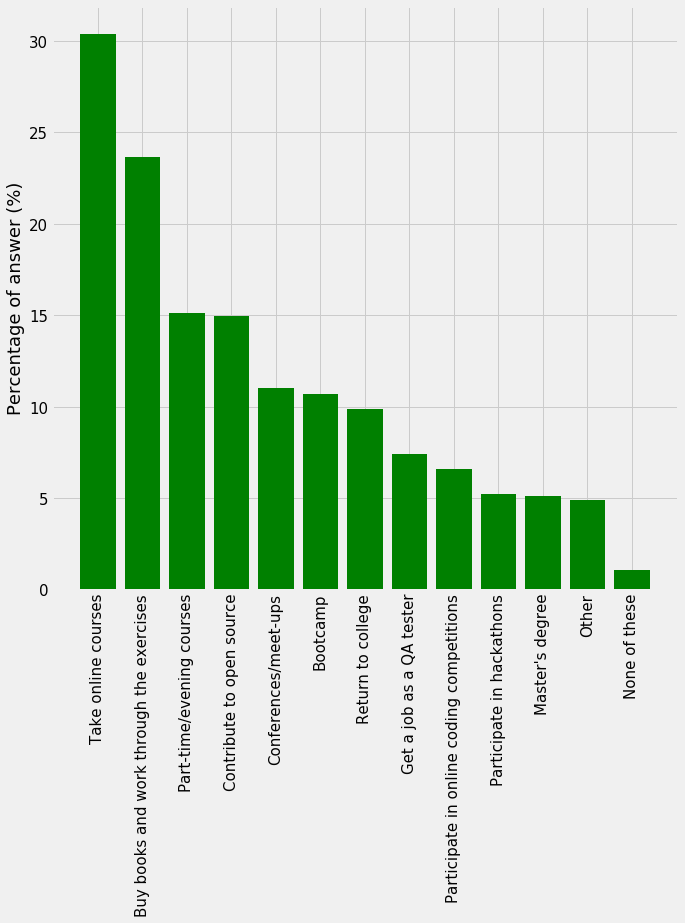

In [10]:
# first we reorder answers by count
AdvCount = dict(sorted(AdvCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_Adv = np.array(list(AdvCount.values()))/len(df_pro) # compute percentage over all participants

plt.bar(list(AdvCount.keys()), perc_Adv*100, color='g')
plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)

---
> __How to break into the field?__

In [11]:
print(
    f'The most given advice is to "{list(AdvCount.keys())[0]}" with {perc_Adv[0]:.2%} of the votes.',
    '\n',
    f'Participate to a bootcamp is only found in {AdvCount["Bootcamp"]/len(df_pro):.2%} of the votes.',
    '\n\n\n'
)


The most given advice is to "Take online courses" with 30.37% of the votes. 
 Participate to a bootcamp is only found in 10.72% of the votes. 





# __Comparing former Education in Position, Salary and Job Satisfaction__
___

In [18]:
[x for x in df_pro.columns if re.search('Boo', x)]

['TimeAfterBootcamp']

Text(0, 0.5, 'Percentage of answer (%)')

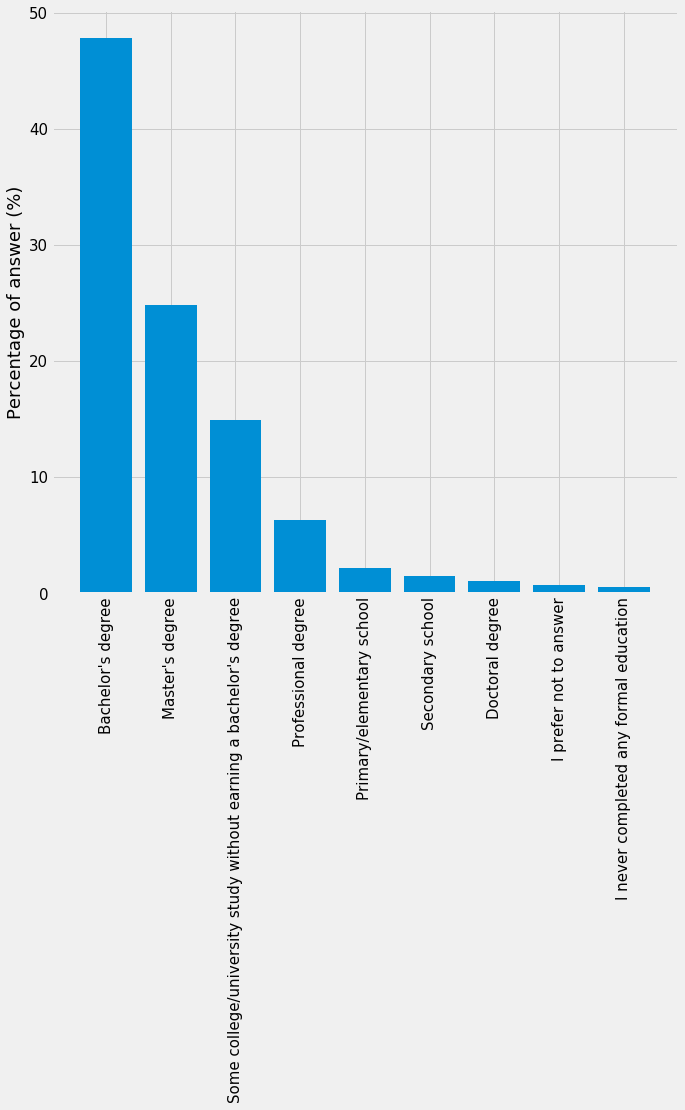

In [12]:
plt.bar(
    x = df_pro['FormalEducation'].unique(),
    height = df_pro['FormalEducation'].value_counts()/len(df_pro)*100
)
plt.xticks(rotation=90)
plt.ylabel('Percentage of answer (%)')

4

## What is Salary for this population looks like?

1. First explore the different currency reported in the dataset

In [12]:
# filter dataset by removing all missing value in salary and missing Currency
df_pro = df_pro.dropna(subset=['Salary', 'Currency']).reset_index(drop=True)

In [14]:
df['Currency'].value_counts()

U.S. dollars ($)               7073
Euros (€)                      5849
Indian rupees (?)              2176
British pounds sterling (£)    2176
Canadian dollars (C$)          1062
Polish zloty (zl)               564
Australian dollars (A$)         469
Russian rubles (?)              366
Brazilian reais (R$)            359
Swedish kroner (SEK)            306
Swiss francs                    300
South African rands (R)         174
Mexican pesos (MXN$)            144
Japanese yen (¥)                123
Chinese yuan renminbi (¥)       121
Singapore dollars (S$)           79
Bitcoin (btc)                    67
Name: Currency, dtype: int64

2. Convert Salary to USD equivalent salary

In [15]:
# We are using our custom function ```convert2USB``` to change all currency if not USD.
df_pro['SalaryConv_USD'] = df_pro[['Salary', 'Currency']].apply(lambda x: convert2USD(x[1], np.round(x[0])),axis=1)

> checking for outliers salary

Text(0.5, 0, 'Survey answer among "Professional"')

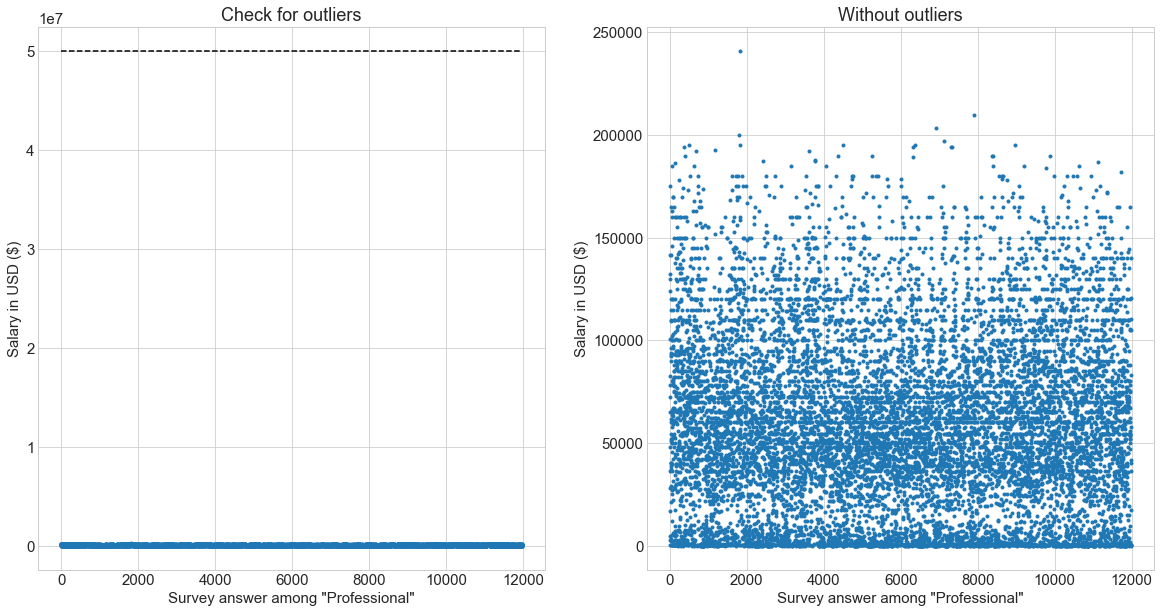

In [68]:
plt.rcParams['figure.figsize']=20, 10

thr = 0.5e8

plt.subplot(1,2,1)
df_pro['SalaryConv_USD'].plot(style='.-', title='Check for outliers')
plt.hlines(y = thr, xmin=0, xmax=len(df_pro), ls='dashed')
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Professional"')

plt.subplot(1,2,2)
df_pro.query(f'SalaryConv_USD < {thr}')['SalaryConv_USD'].plot(style='.', title='Without outliers')
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Professional"')

> __remove outliers in salary__ with threshold over $500000 

In [64]:
df_pro = df_pro.query(f'SalaryConv_USD < {thr}').reset_index(drop=True)

3. Distribution of salary over all "Professional" and by category of professional

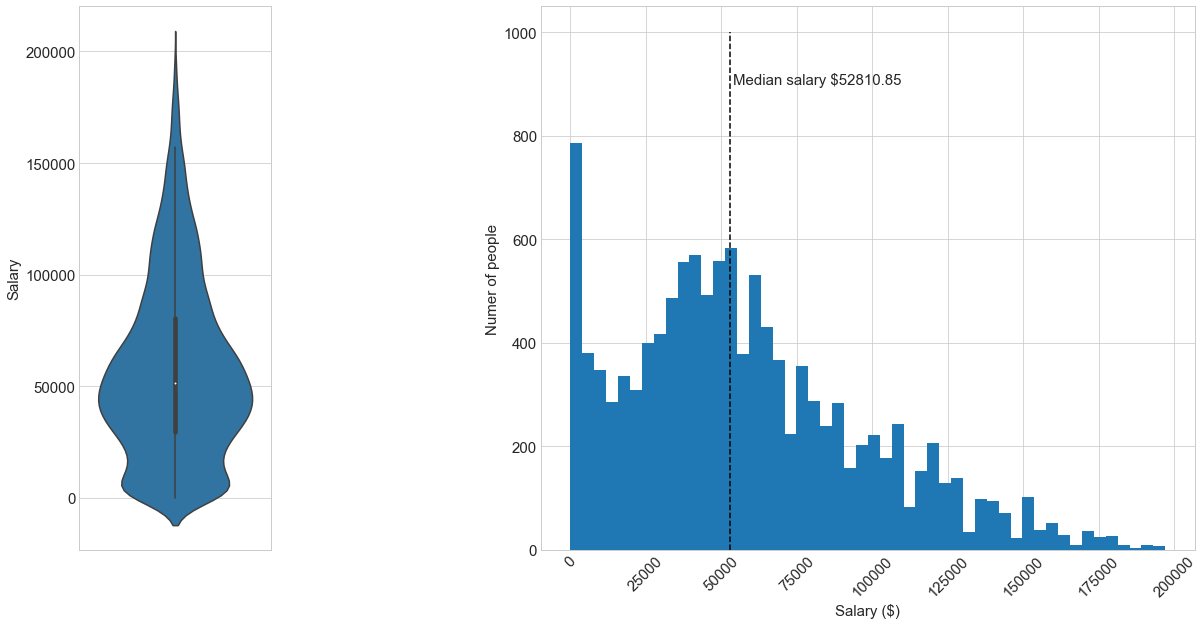

In [65]:
sal_median = df_pro['SalaryConv_USD'].median()

plt.subplot2grid((1,5),(0,2),colspan=3)
df_pro['Salary'].hist(bins=50, xrot=45)
plt.vlines(x = sal_median, ymin=0, ymax=1000, linestyles='--')
plt.text(sal_median+1000, 900, f'Median salary ${sal_median:.2f}')
plt.xlabel('Salary ($)')
plt.ylabel('Numer of people')

plt.subplot2grid((1,5),(0,0),colspan=1)
sns.violinplot(data=df_pro, y='Salary')

In [66]:
df_pro.query('SalaryConv_USD < 1000')['Country'].value_counts()

India                 792
Russian Federation    185
Poland                 72
Mexico                 67
Japan                  47
                     ... 
Nigeria                 1
Czech Republic          1
Spain                   1
Italy                   1
Ghana                   1
Name: Country, Length: 61, dtype: int64

## What kind of Developer type are these professional?

In [69]:
dictIdx_Dev = getChoices(df_pro['DeveloperType'])
list(dictIdx_Dev.keys())

['Other',
 'Embedded applications/devices developer',
 'Web developer',
 'DevOps specialist',
 'Quality assurance engineer',
 'Mobile developer',
 'Desktop applications developer',
 'Graphics programming',
 'Developer with a statistics or mathematics background',
 'Systems administrator',
 'Data scientist',
 'Graphic designer',
 'Database administrator',
 'Machine learning specialist']

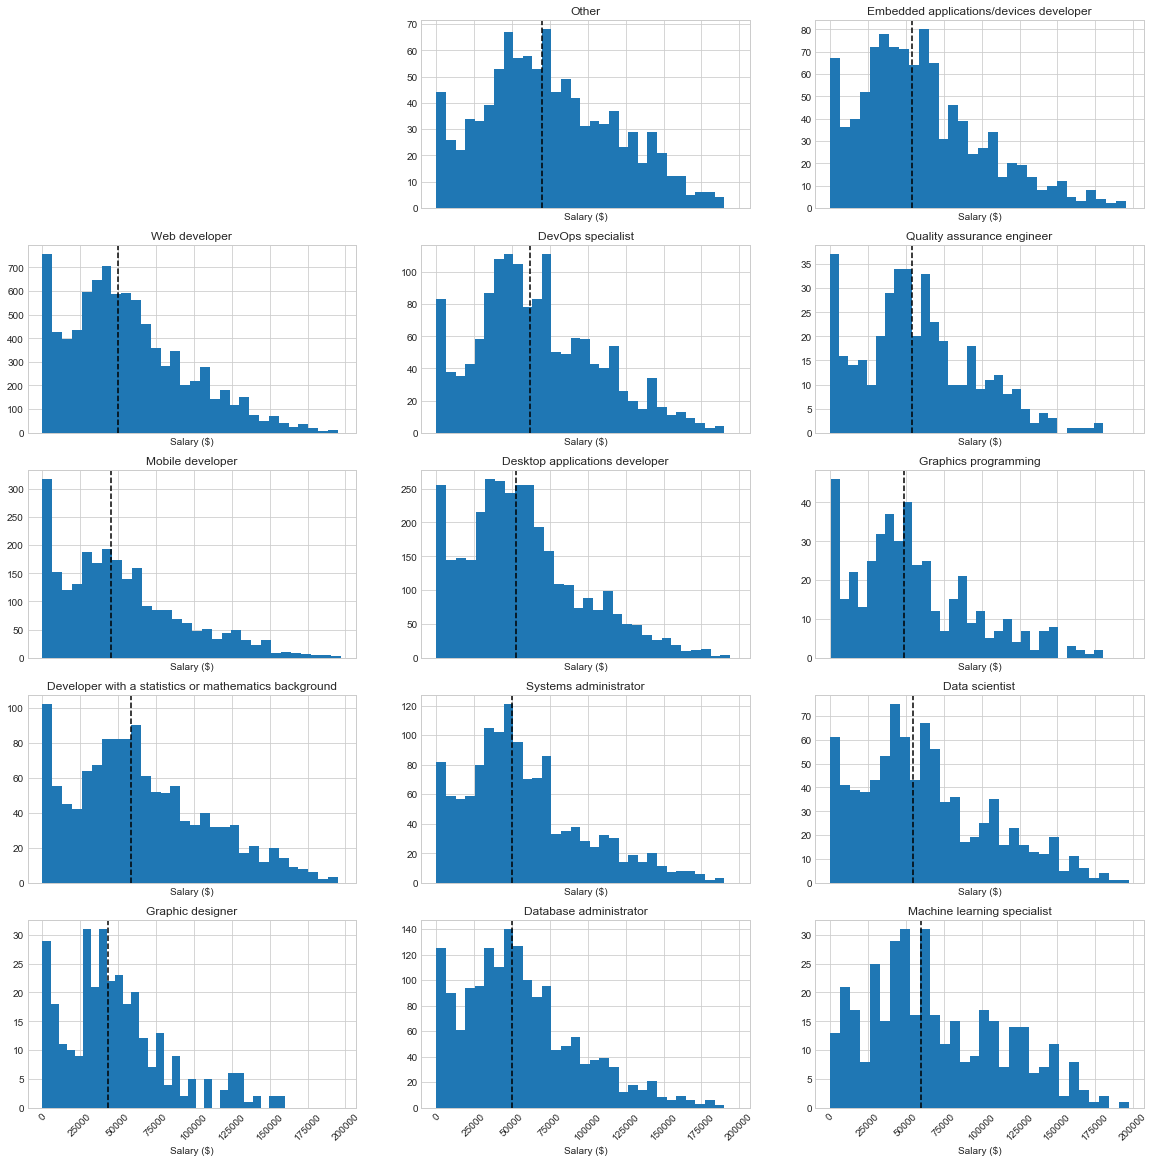

In [70]:
plt.rcParams['figure.figsize']= 20, 20
plt.rcParams['font.size']=10

f, axs = plt.subplots(5, 3, sharex=True)
for win, devtype in enumerate(dictIdx_Dev.keys()):
    idx = dictIdx_Dev[devtype]
    data = df_pro.reindex(idx)['Salary']
    med_sal = data.median()
    axis = axs.ravel()[win+1]
    data.hist(bins=30, xrot=45, ax = axis, density=False)
    axis.axvline(x=med_sal, linestyle='dashed', color='k')
    axis.set_title(devtype)
    axis.set_xlabel('Salary ($)')

f.delaxes(axs.ravel()[0])

___


In [86]:
sal_per_Adv = {k: df_pro['SalaryConv_USD'] for k, v in dictEducAdv.items()}
med_sal_per_Adv = {k: df_pro['SalaryConv_USD'].reindex(v).median() for k, v in dictEducAdv.items()}
std_sal_per_Adv = {k: df_pro['SalaryConv_USD'].reindex(v).std() for k, v in dictEducAdv.items()}
std_sal_per_Adv

{'Get a job as a QA tester': 43420.00922245089,
 'Conferences/meet-ups': 43431.71249463859,
 'Take online courses': 42854.08582494905,
 'Participate in online coding competitions': 41509.02041837788,
 'Buy books and work through the exercises': 43191.07770724858,
 'None of these': 41956.85538917023,
 'Bootcamp': 44611.0043785985,
 'Part-time/evening courses': 42207.51559099282,
 'Contribute to open source': 44117.7361026396,
 'Participate in hackathons': 44570.511576835044,
 'Other': 41026.06884385914,
 'Return to college': 40077.205476382456,
 "Master's degree": 44458.38048642209}

In [87]:
med_sal_per_Adv

{'Get a job as a QA tester': 53445.8260752229,
 'Conferences/meet-ups': 54364.106374375,
 'Take online courses': 50000.0,
 'Participate in online coding competitions': 41080.697413156246,
 'Buy books and work through the exercises': 52810.84619225,
 'None of these': 44133.4265532564,
 'Bootcamp': 54364.106374375,
 'Part-time/evening courses': 48303.9392751486,
 'Contribute to open source': 57806.560000000005,
 'Participate in hackathons': 54364.106374375,
 'Other': 57185.8096891796,
 'Return to college': 54364.106374375,
 "Master's degree": 57806.560000000005}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

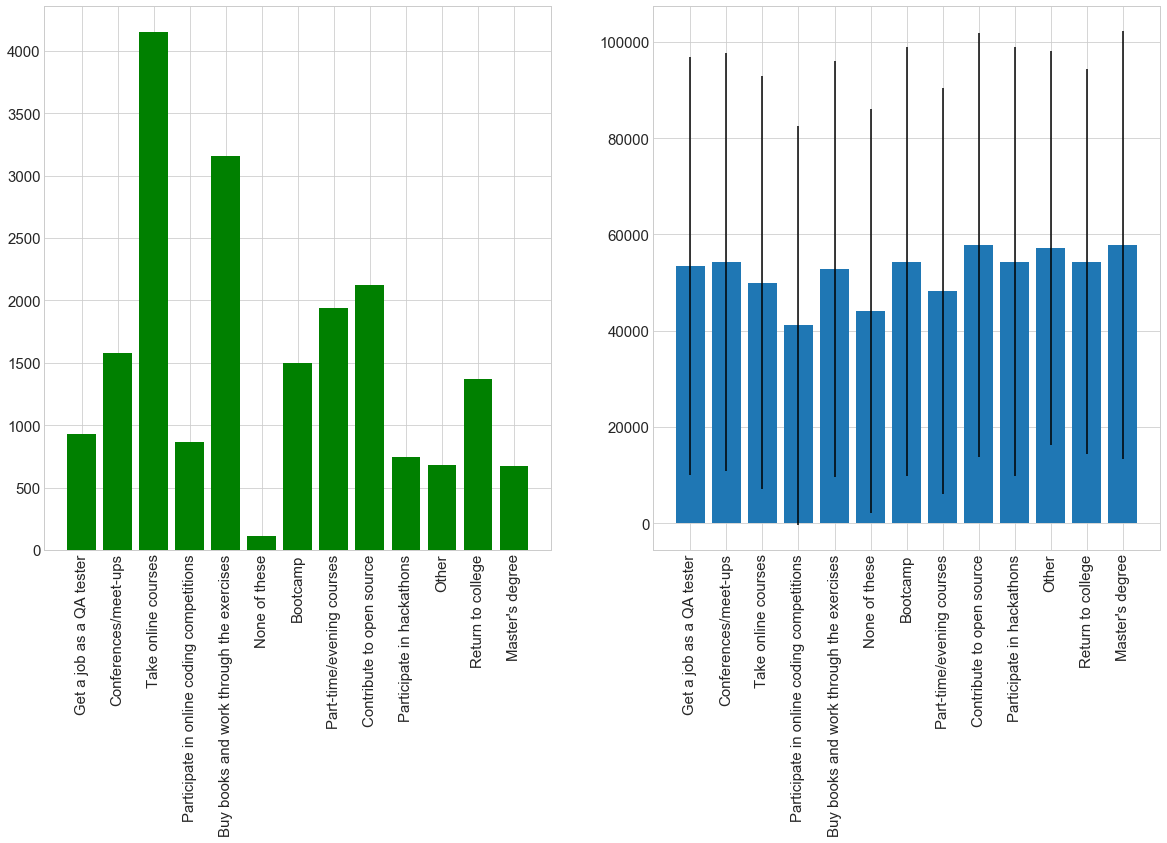

In [91]:
plt.rcParams['figure.figsize']=20, 10
plt.rcParams['font.size']=15

plt.subplot(1,2,1)
plt.bar(list(AdvCount.keys()), AdvCount.values(), color='g')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.bar(list(AdvCount.keys()),  med_sal_per_Adv.values(), yerr = std_sal_per_Adv.values())
plt.xticks(rotation=90)